# **FS25 NLP Project 1: Word Embeddings/Recurrent Neural Networks**

Fabian Dubach

# **Introduction**

The task for this project was to answer common sense questions with the usage of two different architectures: Word embeddings (word2vec, GloVe or fastText) with a classifier and a 2-layer RNN architecture with a classifier (LSTM or GRU). We had to also track the trainings with Wandb (workspace URL: https://wandb.ai/fabian-dubach-hochschule-luzern/CommonsenseQA?nw=nwuserfabiandubach).

# **Setup**

Import all libraries needed to run the code.

In [1]:
import torch
import torch.nn as nn
from tqdm import trange
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from huggingface_hub import hf_hub_download
import gensim
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import time
from datetime import datetime
import matplotlib.pyplot as plt
import os
import wandb
from lightning.pytorch.loggers import WandbLogger
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

c:\Users\fabia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup random seed to ensure reproducibility.

_Info about the seed value: The field of natural language processing began in the 1940s, after World War II. At this time, people recognized the importance of translation from one language to another and hoped to create a machine that could do this sort of translation automatically._

In [2]:
SEED = 1940

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Download tokenizer files.

In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\fabia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load pre-trained FastText word embeddings (300 dimensions)

I first wanted to choose GloVe, because I've seen that GloVe performs well on semantic similarity and analogical reasoning. Due to the fact that GloVe can only handle uncased embeddings (lowercase), I chose to use FastText. I used 300 dimensions, because it represents word meanings more completely than smaller options (50- or 100 dimensions) while still being practical to use.

In [4]:
model_path = hf_hub_download(repo_id="facebook/fasttext-en-vectors", filename="model.bin")

In [5]:
fasttext_model = gensim.models.fasttext.load_facebook_model(model_path)
wv = fasttext_model.wv

Look at vector- and vocab size from the loaded embedding.

In [7]:
print("Vector size:", wv.vector_size)
print("Vocab size:", len(wv.index_to_key))

Vector size: 300
Vocab size: 2000000


Check if known and unknown words create vectors.

In [8]:
print(wv["Hello"])
print(wv["jwadAJKJDwljlkdajl"])

[ 0.18165089  0.11567269  0.0433396   0.07706802  0.05069138  0.03688334
  0.07828845  0.04980808 -0.00644083  0.01029488 -0.04722646 -0.00791209
 -0.11451723  0.03025086  0.09307548  0.01062883 -0.07683911 -0.10517459
  0.00246387  0.07702646  0.04039837  0.01229953 -0.11466632  0.05460778
  0.08104917  0.0413662   0.01208615  0.08066231 -0.10937778  0.0893073
 -0.03935073 -0.03060348 -0.08027591  0.08209406 -0.03217232 -0.03641732
  0.01242283  0.05759722 -0.05894108  0.02777894 -0.18341364 -0.05084793
  0.02241275  0.00440608  0.07912826  0.04474901 -0.03937861 -0.0721626
  0.05589562  0.02635202  0.01346619  0.0173357   0.12057565 -0.019653
 -0.01023086 -0.00223926  0.03043848  0.00747647  0.04588774  0.06308782
 -0.1178913   0.10388953 -0.03564711  0.12567218  0.1470628   0.06018791
 -0.0574099   0.01620604  0.12471652  0.04412995  0.10071367 -0.02047683
 -0.13367647 -0.07360457 -0.13447621 -0.03744629 -0.0009886   0.0684141
  0.06370986  0.05818591 -0.04122961 -0.0223539   0.0769

For the project, we had to use the CommonsenseQA dataset, which is a multiple-choice question answering dataset that contains 12'247 different questions and was developed to benchmark machine understanding of everyday knowledge. For each questions there are 5 given answer choices, where only one of them is correct. To be able to answer these questions, "commonsense" is needed. The dataset is available on HuggingFace: https://huggingface.co/datasets/tau/commonsense_qa.

I split the dataset into training, validation and test sets to allow for model development and evaluation. I used the last 1'000 examples from the training set for validation and the original validation set for testing, since the real test set has no answer keys.

In [9]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


# **Data Exploration**

In this section I tried to get some insight to understand its structure and patterns.

### 1. Explore dataset structure

In [10]:
print("\033[4m" + "Dataset Features" + "\033[0m")
for feature in train.features:
    print(feature)
print("\n" + "\033[4m" + "Example" + "\033[0m")
for feature in train.features:
    print(feature + ":", train[0][str(feature)])

Dataset Features
id
question
question_concept
choices
answerKey

Example
id: 075e483d21c29a511267ef62bedc0461
question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
question_concept: punishing
choices: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}
answerKey: A


### 2. Get a general info about each dataset

In [11]:
def dataset_to_df(dataset):
    return pd.DataFrame(dataset)

train_df = dataset_to_df(train)
valid_df = dataset_to_df(valid)
test_df = dataset_to_df(test)

In [12]:
print("\033[4m" + "Train Info" + "\033[0m")
print(train_df.info())

Train Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8741 entries, 0 to 8740
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                8741 non-null   object
 1   question          8741 non-null   object
 2   question_concept  8741 non-null   object
 3   choices           8741 non-null   object
 4   answerKey         8741 non-null   object
dtypes: object(5)
memory usage: 341.6+ KB
None


In [13]:
print("\033[4m" + "Validation Info" + "\033[0m")
print(valid_df.info())

Validation Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1000 non-null   object
 1   question          1000 non-null   object
 2   question_concept  1000 non-null   object
 3   choices           1000 non-null   object
 4   answerKey         1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB
None


In [14]:
print("\033[4m" + "Test Info" + "\033[0m")
print(test_df.info())

Test Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1221 entries, 0 to 1220
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1221 non-null   object
 1   question          1221 non-null   object
 2   question_concept  1221 non-null   object
 3   choices           1221 non-null   object
 4   answerKey         1221 non-null   object
dtypes: object(5)
memory usage: 47.8+ KB
None


### 3. Analyze question lengths

In [15]:
combined_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

combined_df['question_length'] = combined_df['question'].apply(len)
combined_df['question_word_count'] = combined_df['question'].apply(lambda x: len(x.split()))

print("\033[4m" + "Question length (characters)" + "\033[0m")
print(f"Min: {combined_df['question_length'].min()}")
print(f"Max: {combined_df['question_length'].max()}")
print(f"Mean: {combined_df['question_length'].mean():.2f}")
print(f"Median: {combined_df['question_length'].median()}")

print("\n\033[4m" + "Question Word Count" + "\033[0m")
print(f"Min: {combined_df['question_word_count'].min()}")
print(f"Max: {combined_df['question_word_count'].max()}")
print(f"Mean: {combined_df['question_word_count'].mean():.2f}")
print(f"Median: {combined_df['question_word_count'].median()}")

Question length (characters)
Min: 15
Max: 376
Mean: 69.31
Median: 64.0

Question Word Count
Min: 3
Max: 63
Mean: 13.23
Median: 12.0


### 4. Analyze option lengths

In [16]:
def get_option_lengths(choices):
    return [len(text) for text in choices['text']]

def get_option_word_counts(choices):
    return [len(text.split()) for text in choices['text']]

combined_df['option_lengths'] = combined_df['choices'].apply(get_option_lengths)
combined_df['option_word_counts'] = combined_df['choices'].apply(get_option_word_counts)

# Flatten the lists for analysis
all_option_lengths = [length for lengths in combined_df['option_lengths'] for length in lengths]
all_option_word_counts = [count for counts in combined_df['option_word_counts'] for count in counts]

print("\033[4m" + "Option length (characters)" + "\033[0m")
print(f"Min: {min(all_option_lengths)}")
print(f"Max: {max(all_option_lengths)}")
print(f"Mean: {np.mean(all_option_lengths):.2f}")
print(f"Median: {np.median(all_option_lengths)}")

print("\033[4m" + "\nOption word count" + "\033[0m")
print(f"Min: {min(all_option_word_counts)}")
print(f"Max: {max(all_option_word_counts)}")
print(f"Mean: {np.mean(all_option_word_counts):.2f}")
print(f"Median: {np.median(all_option_word_counts)}")

Option length (characters)
Min: 3
Max: 149
Mean: 9.34
Median: 9.0

Option word count
Min: 1
Max: 26
Mean: 1.52
Median: 1.0


### 5. Analyze answer distribution

In [17]:
def extract_answer_letter(example):
    return example['answerKey']

combined_df['answer_letter'] = combined_df.apply(extract_answer_letter, axis=1)

print("\033[4m" + "Answer Distribution" + "\033[0m")
print(combined_df['answer_letter'].value_counts(), "\n")
print(combined_df['answer_letter'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

Answer Distribution
answer_letter
D    2236
B    2228
C    2187
E    2163
A    2148
Name: count, dtype: int64 

answer_letter
D     20.4%
B    20.32%
C    19.95%
E    19.73%
A    19.59%
Name: proportion, dtype: object


### 6. Extract common question words/phrases

In [18]:
def get_common_words(text_series, top_n=20):
    stop_words = set(stopwords.words('english'))
    all_words = []
    
    for text in text_series:
        words = word_tokenize(text.lower())
        filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
        all_words.extend(filtered_words)
    
    return Counter(all_words).most_common(top_n)

print("\033[4m" + "Common Words in Questions" + "\033[0m")
common_words = get_common_words(train_df['question'], 10)
for word, count in common_words:
    print(f"{word}: {count}")

Common Words in Questions
would: 1101
people: 694
might: 669
likely: 637
someone: 556
find: 509
could: 502
person: 498
get: 372
one: 367


### 7. Visualize question length distribution

Text(0, 0.5, 'Frequency')

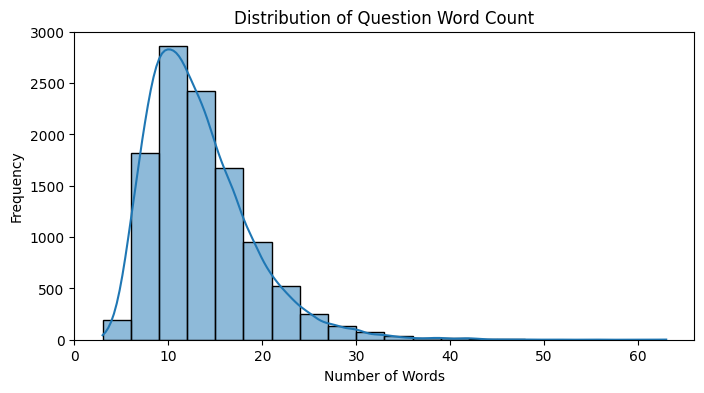

In [19]:
plt.figure(figsize=(8, 4))
sns.histplot(combined_df['question_word_count'], bins=20, kde=True)
plt.title('Distribution of Question Word Count')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

### 8. Visualize answer distribution

Text(0, 0.5, 'Count')

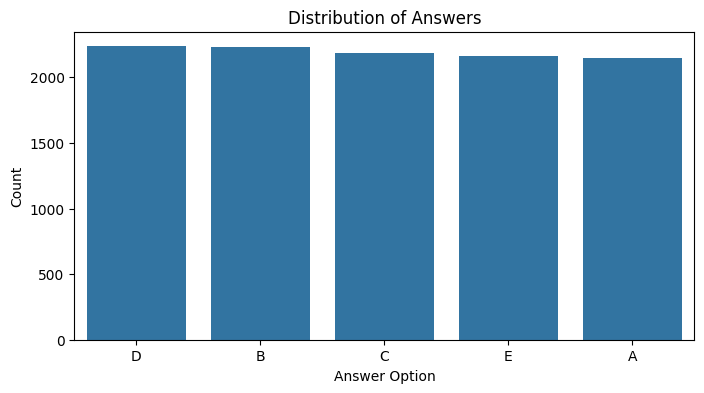

In [20]:
plt.figure(figsize=(8, 4))
sns.countplot(x='answer_letter', data=combined_df, order=combined_df['answer_letter'].value_counts().index)
plt.title('Distribution of Answers')
plt.xlabel('Answer Option')
plt.ylabel('Count')

# **Preprocessing**

For the preprocessing I looked at the following points:

1. Tokenization
2. Lowercasing, stemming, lemmatizing, stopword/punctuation removal 
3. Removal of unknown/other words 
4. Format cleaning (e.g. html-extracted text) 
5. Truncation 
6. Feature selection 

Here are my decisions and justifications for using or not using the above listed preprocessing methods:

1. Tokenization is absolutely mandatory.
2. I chose not to use lowercasing to keep the semantic meaning of the words. Stemming and lemmatizing are not needed, because FastText already captures semantic similarities. Stopword/Punctuation removal is generally not a needed for a RNN due to the fact that the model can then learn to ignore irrelevant words by itself.
3. Removal of unknown/other words is also not needed, because FastText can handle them.
4. Format cleaning is not needed, because the CommonsenseQA dataset doesn't include any markup text.
5. Due to the fact that the longest question is 376 characters long, truncation is not needed.
6. Feature selection is also not needed. RNNs typically work with the full sequence rather than selected features.

In [21]:
def preprocessing(text):
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens

### **Word Embedding**

The get_embedding function transforms any text sentence into a fixed-length vector representation by averaging the word embeddings of each token in the sentence. If no tokens were found, a zero vector is being returned.

In [22]:
def get_embedding(sentence):
    tokens = preprocessing(sentence)
    word_vectors = []
    for token in tokens:
        try:
            # Correct syntax for fasttext_model
            word_vectors.append(fasttext_model.wv[token])  # Use .wv attribute
        except KeyError:
            # Skip tokens not in vocabulary
            continue
    
    # Return the mean of the word vectors
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(fasttext_model.vector_size)  # Return a zero vector if no tokens were found

For the model to interpret the answers correctly, I converted the answer keys into numerical indices (0, 1, 2, 3, 4).

In [23]:
def answer_key_to_index(answer_key):
  return ord(answer_key) - ord("A")

The compute_embeddings function creates embeddings for every text data (questions and choices).

In [24]:
def compute_embeddings(example):
    question_embeddings = get_embedding(example["question"])
    choice_embeddings = [get_embedding(choice) for choice in example["choices"]["text"]]
    
    # Save embeddings as lists so they can be stored in the dataset
    example["question_emb"] = question_embeddings.tolist()
    example["choice_embs"] = [embedding.tolist() for embedding in choice_embeddings]
    return example

train = train.map(compute_embeddings)
valid = valid.map(compute_embeddings)

Map: 100%|██████████| 1000/1000 [00:01<00:00, 666.28 examples/s]


Implement a class which can convert a regular dataset into a PyTorch-compatible dataset.

In [25]:
class CommonsenseQADataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question_tensor = torch.tensor(example["question_emb"]).float()
        choices_tensor = torch.tensor(example["choice_embs"]).float()
        answer_index = answer_key_to_index(example["answerKey"])
        return question_tensor, choices_tensor, torch.tensor(answer_index).long()

Create a PyTorch-compatible dataset for the train and the validation dataset.

In [26]:
train_dataset = CommonsenseQADataset(train)
valid_dataset = CommonsenseQADataset(valid)

Batch the dataset for training.

In [27]:
embedding_batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=embedding_batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=embedding_batch_size, shuffle=True, num_workers=0)

Verify the structure and shapes of the data batches.

In [28]:
for batch in train_loader:
    print(batch[0].shape, batch[1].shape, batch[2].shape, batch[2])
    break

torch.Size([32, 300]) torch.Size([32, 5, 300]) torch.Size([32]) tensor([2, 3, 0, 1, 4, 4, 2, 1, 4, 4, 0, 0, 0, 4, 2, 3, 0, 2, 3, 2, 2, 2, 1, 4,
        2, 1, 1, 3, 1, 4, 0, 2])


### **RNN**

In [55]:
class CommonsenseQARNNDataset(Dataset):
    def __init__(self, hf_dataset, word_vectors, embedding_dim=300):
        self.data = hf_dataset
        self.wv = word_vectors
        self.embedding_dim = embedding_dim
        self.SEP_TOKEN = "<SEP>"
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data[idx]
        
        # Tokenize question and choices
        question_tokens = preprocessing(example["question"])
        choice_tokens = [preprocessing(choice) for choice in example["choices"]["text"]]
        
        # Create sequences and lengths for each choice
        sequences = []
        lengths = []
        for choice in choice_tokens:
            # Combine question and choice
            full_sequence = question_tokens + [self.SEP_TOKEN] + choice
            
            # Convert to embeddings
            embeddings = []
            for token in full_sequence:
                try:
                    # Use pretrained embedding
                    if token == self.SEP_TOKEN:
                        embeddings.append(torch.randn(self.embedding_dim) * 0.1)
                    else:
                        embeddings.append(torch.tensor(self.wv[token]))
                except KeyError:
                    # For OOV words, use random embedding
                    embeddings.append(torch.randn(self.embedding_dim) * 0.1)
            
            # Convert to tensor
            sequences.append(torch.stack(embeddings))
            lengths.append(len(embeddings))
        
        # Convert answer to index
        answer = ord(example["answerKey"]) - ord("A")
        
        return sequences, torch.tensor(lengths), torch.tensor(answer)

In [56]:
def rnn_collate_batch(batch):
    # Separate sequences, lengths, and answers
    all_sequences = []
    all_lengths = []
    all_answers = []
    
    batch_size = len(batch)
    num_choices = len(batch[0][0])  # Number of choices per example
    
    for sequences, lengths, answer in batch:
        all_sequences.extend(sequences)
        all_lengths.append(lengths)
        all_answers.append(answer)
    
    # Combine and sort lengths
    lengths_tensor = torch.cat(all_lengths)
    sorted_indices = torch.argsort(lengths_tensor, descending=True)
    
    # Reorder sequences and lengths based on sorted indices
    sorted_sequences = [all_sequences[i] for i in sorted_indices]
    sorted_lengths = lengths_tensor[sorted_indices]
    
    # Pad sequences
    padded_sequences = pad_sequence(sorted_sequences, batch_first=True)
    
    # Create indices to reconstruct original batch order
    indices = torch.arange(len(sorted_indices)).view(batch_size, num_choices)
    
    # Stack answers
    answers_tensor = torch.stack(all_answers)
    
    return padded_sequences, sorted_lengths, indices, answers_tensor

In [57]:
train_rnn_dataset = CommonsenseQARNNDataset(
    train, 
    wv,
    embedding_dim=300
)

valid_rnn_dataset = CommonsenseQARNNDataset(
    valid, 
    wv,
    embedding_dim=300
)

# Check dataset sample
sample_idx = 0
sequences, lengths, answer = train_rnn_dataset[sample_idx]
print(f"Number of sequences: {len(sequences)}")
for i, sequence in enumerate(sequences):
    print(f"Sequence {i} shape: {sequence.shape}")
print(f"Sequence lengths: {lengths}")
print(f"Correct answer: {answer.item()}")

Number of sequences: 5
Sequence 0 shape: torch.Size([26, 300])
Sequence 1 shape: torch.Size([26, 300])
Sequence 2 shape: torch.Size([26, 300])
Sequence 3 shape: torch.Size([27, 300])
Sequence 4 shape: torch.Size([26, 300])
Sequence lengths: tensor([26, 26, 26, 27, 26])
Correct answer: 0


In [36]:
train_rnn_loader = DataLoader(
    train_rnn_dataset,
    batch_size=128,
    shuffle=True,
    collate_fn=rnn_collate_batch,
    num_workers=0,  # Set to 0 for debugging
    pin_memory=False
)

valid_rnn_loader = DataLoader(
    valid_rnn_dataset,
    batch_size=256,
    shuffle=False,
    collate_fn=rnn_collate_batch,
    num_workers=0,
    pin_memory=False
)

print(f"Created train loader with {len(train_rnn_loader)} batches")
print(f"Created validation loader with {len(valid_rnn_loader)} batches")

Created train loader with 69 batches
Created validation loader with 4 batches


# **Model**

### Word embeddings

In [37]:
class WordEmbeddingQAClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, dropout_rate):
        super(WordEmbeddingQAClassifier, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # First layer: concatenated embedding dimension
        self.fc1 = nn.Linear(2 * embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        
        # Output layer for classification
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, question, choices):
        # Expand question to match choices dimension
        question_expanded = question.unsqueeze(1).expand(-1, choices.size(1), -1)
        
        # Concatenate question and choice embeddings
        combined = torch.cat((question_expanded, choices), dim=2)

        # First layer with ReLU and Dropout
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Final layer
        x = self.fc2(x)
        return x.squeeze(-1)

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [39]:
embedding_dim = 300
hidden_dim = 64
dropout_rate = 0.2

In [40]:
model = WordEmbeddingQAClassifier(embedding_dim, hidden_dim, dropout_rate)
model = model.to(device)

print(model)

WordEmbeddingQAClassifier(
  (fc1): Linear(in_features=600, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


### RNN

In [58]:
class QARNNModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=128, num_choices=5, dropout_rate=0.2):
        super(QARNNModel, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_choices = num_choices
        
        # 2-layer bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=True
        )
        
        # Classification head
        lstm_output_dim = hidden_dim * 2  # bidirectional = *2
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, padded_sequences, sequence_lengths, indices):
        """Process all sequences together and then reshape for classification"""
        batch_size = indices.size(0)
        
        # Pack padded sequences with enforce_sorted=False
        packed = pack_padded_sequence(
            padded_sequences, 
            sequence_lengths.cpu(), 
            batch_first=True,
            enforce_sorted=False
        )
        
        # Run through LSTM
        _, (hidden, _) = self.lstm(packed)
        
        # Get final hidden states from both directions
        final_hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        
        # Process through classifier
        logits = self.classifier(final_hidden).squeeze(-1)
        
        # Rearrange back to original order
        all_logits = torch.zeros(batch_size, self.num_choices, device=padded_sequences.device)
        for batch_idx in range(batch_size):
            for choice_idx in range(self.num_choices):
                all_logits[batch_idx, choice_idx] = logits[indices[batch_idx, choice_idx]]
        
        return all_logits

# **Training**

In [59]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
embedding_run = wandb.init(
  project="CommonsenseQA",
  name=f"word_embedding-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "word_embedding",
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "batch_size": 256,  # Smaller batch size
    "epoch": 100,
    "dropout_rate": dropout_rate,
    "weight_decay": 1e-5,  # Very light weight decay
    "label_smoothing": 0.0,  # No label smoothing initially
    "gradient_clipping": 1.0,
    "max_lr": 0.001,
  },
  reinit=True,
)

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [66]:
def save_checkpoint(model, optimizer, epoch, save_path, best_val_accuracy):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_accuracy': best_val_accuracy
    }
    torch.save(checkpoint, save_path)
    try:
        if 'best_model' in save_path:
            wandb.log({
                "best_model_checkpoint": {
                    "path": save_path,
                    "epoch": epoch,
                    "val_accuracy": best_val_accuracy
                }
            })
    except Exception as e:
        print(f"Error logging checkpoint to wandb: {e}")

In [ ]:
def train_word_embedding(
    model, 
    train_loader, 
    valid_loader, 
    criterion, 
    optimizer, 
    num_epochs, 
    device, 
    checkpoint_dir='checkpoints', 
    save_interval=10,
):
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Initialize best validation accuracy
    best_val_accuracy = 0
    start_epoch = 0
    
    # Training loop
    for epoch in (pbar := trange(start_epoch, num_epochs)):
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")

        model.train()
        train_total_loss = 0.0
        train_correct = 0
        train_total = 0

        for question_batch, choices_batch, y_batch in train_loader:
            optimizer.zero_grad()

            question_batch = question_batch.to(device)
            choices_batch = choices_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            outputs = model(question_batch, choices_batch)

            # Compute loss
            train_batch_loss = criterion(outputs, y_batch)
            train_total_loss += train_batch_loss.item()

            # Compute accuracy
            train_predictions = torch.argmax(outputs, dim=1)
            train_correct += (train_predictions == y_batch).sum().item()
            train_total += y_batch.size(0)

            # Backward pass
            train_batch_loss.backward()
            optimizer.step()

        # Calculate train statistics
        avg_train_loss = train_total_loss / len(train_loader)
        train_accuracy = train_correct / train_total

        # Evaluate
        model.eval()
        val_correct = 0
        val_total = 0
        val_total_loss = 0

        with torch.no_grad():
            for question_batch, choices_batch, y_batch in valid_loader:
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                y_batch = y_batch.to(device)

                val_outputs = model(question_batch, choices_batch)

                # Calculate validation loss
                val_batch_loss = criterion(val_outputs, y_batch)
                val_total_loss += val_batch_loss.item()

                val_predictions = torch.argmax(val_outputs, dim=1)
                val_correct += (val_predictions == y_batch).sum().item()
                val_total += y_batch.size(0)

        # Calculate validation statistics
        avg_val_loss = val_total_loss / len(valid_loader)
        val_accuracy = val_correct / val_total
        
        pbar.set_postfix({
            "train_loss": avg_train_loss, 
            "train_acc": train_accuracy, 
            "val_acc": val_accuracy
        })

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy,
            "learning_rate": optimizer.param_groups[0]['lr'],
        })

        # Save checkpoint periodically
        if (epoch + 1) % save_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
            save_checkpoint(model, optimizer, epoch+1, checkpoint_path, best_val_accuracy)

        # Save best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_path = os.path.join(checkpoint_dir, 'best_model.pt')
            save_checkpoint(model, optimizer, epoch+1, best_model_path, best_val_accuracy)

    # Final save
    final_model_path = os.path.join(checkpoint_dir, 'final_model.pt')
    save_checkpoint(model, optimizer, num_epochs, final_model_path, best_val_accuracy)
    
    wandb.finish()
    
    return model, best_val_accuracy

In [ ]:
# Define checkpoint directory
checkpoint_dir = './checkpoints/embedding'
os.makedirs(checkpoint_dir, exist_ok=True)

# Optional: Resume from a previous checkpoint
resume_checkpoint = None  # Set to checkpoint path if resuming

# Replace your existing training loop with this
model, best_val_accuracy = train_word_embedding(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=embedding_run.config.epoch,
    device=device,
    checkpoint_dir=checkpoint_dir,
    save_interval=1  # Save a checkpoint every 5 epochs
)

print(best_val_accuracy)

### **RNN Training**

In [91]:
embedding_dim = 300  # Same as word vectors
hidden_dim = 128     # Hidden dimension for LSTM
dropout_rate=0.2
num_epochs = 100

# Create the RNN model
rnn_model = QARNNModel(  # Updated name
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout_rate=dropout_rate
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
rnn_model = rnn_model.to(device)

# Print model summary
print(rnn_model)

Using device: cuda
QARNNModel(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [92]:
# Modify the training function to use the updated save_checkpoint
def train_rnn_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs, device, checkpoints_path=None, log_wandb=True, gradient_clip_val=1.0):
    best_val_accuracy = 0.0
    training_start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc="Training") as progress_bar:
            for batch_data in progress_bar:
                # Unpack the batch data
                padded_sequences, sequence_lengths, indices, answers = batch_data
                
                # Move to device
                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(padded_sequences, sequence_lengths, indices)
                loss = criterion(outputs, answers)
                
                # Backward pass
                loss.backward()
                if gradient_clip_val > 0:
                    nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()
                
                # Statistics
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += answers.size(0)
                train_correct += (predicted == answers).sum().item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{train_correct/train_total:.4f}"
                })
        
        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_data in tqdm(valid_loader, desc="Validation"):
                # Unpack the batch data
                padded_sequences, sequence_lengths, indices, answers = batch_data
                
                # Move to device
                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)
                
                # Forward pass
                outputs = model(padded_sequences, sequence_lengths, indices)
                loss = criterion(outputs, answers)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += answers.size(0)
                val_correct += (predicted == answers).sum().item()
        
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(valid_loader)
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
            best_val_accuracy = val_accuracy
            best_model_path = os.path.join(checkpoints_path, 'best_rnn_model.pt')
            save_checkpoint(model, optimizer, epoch+1, best_val_accuracy, best_model_path)
        
        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Log to wandb
        if log_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
    
    print(f"Training completed in {(time.time() - training_start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    
    # Final metrics for wandb
    if log_wandb:
        wandb.run.summary["best_val_accuracy"] = best_val_accuracy
        wandb.finish()
    
    return model, best_val_accuracy

In [93]:
rnn_run = wandb.init(
  project="CommonsenseQA",
  name=f"rnn-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "rnn",
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "batch_size": 256,  # Smaller batch size
    "epoch": 100,
    "dropout_rate": dropout_rate,
    "weight_decay": 1e-5,  # Very light weight decay
    "label_smoothing": 0.0,  # No label smoothing initially
    "gradient_clipping": 1.0,
    "max_lr": 0.001,
  },
  reinit=True,
)

In [94]:
checkpoints_path = "./checkpoints/rnn_model"
os.makedirs(checkpoints_path, exist_ok=True)

In [95]:
def save_checkpoint(model, optimizer, epoch, best_val_accuracy, save_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_accuracy': best_val_accuracy
    }
    torch.save(checkpoint, save_path)
    try:
        if 'best_model' in save_path:
            wandb.log({
                "best_model_checkpoint": {
                    "path": save_path,
                    "epoch": epoch,
                    "val_accuracy": best_val_accuracy
                }
            })
    except Exception as e:
        print(f"Error logging checkpoint to wandb: {e}")

def train_rnn_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device, checkpoints_path=None, log_wandb=True, gradient_clip_val=1.0):
    best_val_accuracy = 0.0
    training_start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc="Training") as progress_bar:
            for batch_data in progress_bar:
                # Unpack the batch data
                padded_sequences, sequence_lengths, indices, answers = batch_data
                
                # Move to device
                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(padded_sequences, sequence_lengths, indices)
                loss = criterion(outputs, answers)
                
                # Backward pass
                loss.backward()
                if gradient_clip_val > 0:
                    nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                optimizer.step()
                
                # Statistics
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += answers.size(0)
                train_correct += (predicted == answers).sum().item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{train_correct/train_total:.4f}"
                })
        
        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_data in tqdm(valid_loader, desc="Validation"):
                # Unpack the batch data
                padded_sequences, sequence_lengths, indices, answers = batch_data
                
                # Move to device
                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)
                
                # Forward pass
                outputs = model(padded_sequences, sequence_lengths, indices)
                loss = criterion(outputs, answers)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += answers.size(0)
                val_correct += (predicted == answers).sum().item()
        
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(valid_loader)
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
            best_val_accuracy = val_accuracy
            best_model_path = os.path.join(checkpoints_path, 'best_rnn_model.pt')
            save_checkpoint(model, optimizer, epoch+1, best_val_accuracy, best_model_path)
        
        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Log to wandb
        if log_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
    
    print(f"Training completed in {(time.time() - training_start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    
    # Final metrics for wandb
    if log_wandb:
        wandb.run.summary["best_val_accuracy"] = best_val_accuracy
        wandb.finish()
    
    return model, best_val_accuracy

# Modify the training setup to remove scheduler from checkpoint saving
try:
    trained_rnn_model, best_rnn_accuracy = train_rnn_model(
        model=rnn_model,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_rnn_loader,
        valid_loader=valid_rnn_loader,
        num_epochs=num_epochs,
        device=device,
        checkpoints_path=checkpoints_path,
        log_wandb=True,
        gradient_clip_val=rnn_run.config.gradient_clipping
    )
    print(f"RNN Training complete! Best validation accuracy: {best_rnn_accuracy:.4f}")
except Exception as e:
    print(f"Training failed with error: {e}")
    import traceback
    import sys
    
    # Print detailed traceback
    print("Detailed error traceback:")
    traceback.print_exc()
    
    # Try to save the model
    try:
        torch.save(rnn_model.state_dict(), os.path.join(checkpoints_path, "emergency_save.pt"))
        print("Model saved in emergency mode")
    except Exception as save_error:
        print(f"Failed to save model: {save_error}")
    
    # Re-raise the original exception
    raise


Epoch 1/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


Validation accuracy improved from 0.0000 to 0.1960
Train Loss: 1.6096, Train Acc: 0.1960
Val Loss: 1.6094, Val Acc: 0.1960

Epoch 2/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


Train Loss: 1.6095, Train Acc: 0.2050
Val Loss: 1.6094, Val Acc: 0.1940

Epoch 3/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


Validation accuracy improved from 0.1960 to 0.2030
Train Loss: 1.6094, Train Acc: 0.1953
Val Loss: 1.6094, Val Acc: 0.2030

Epoch 4/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Train Loss: 1.6095, Train Acc: 0.1968
Val Loss: 1.6094, Val Acc: 0.1740

Epoch 5/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Validation accuracy improved from 0.2030 to 0.2140
Train Loss: 1.6093, Train Acc: 0.1973
Val Loss: 1.6094, Val Acc: 0.2140

Epoch 6/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Train Loss: 1.6097, Train Acc: 0.1936
Val Loss: 1.6094, Val Acc: 0.1870

Epoch 7/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


Train Loss: 1.6097, Train Acc: 0.1946
Val Loss: 1.6094, Val Acc: 0.1810

Epoch 8/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Train Loss: 1.6095, Train Acc: 0.1991
Val Loss: 1.6094, Val Acc: 0.1900

Epoch 9/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Train Loss: 1.6094, Train Acc: 0.2043
Val Loss: 1.6094, Val Acc: 0.2020

Epoch 10/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Validation accuracy improved from 0.2140 to 0.2180
Train Loss: 1.6095, Train Acc: 0.2033
Val Loss: 1.6094, Val Acc: 0.2180

Epoch 11/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


Train Loss: 1.6095, Train Acc: 0.1969
Val Loss: 1.6094, Val Acc: 0.1980

Epoch 12/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


Train Loss: 1.6097, Train Acc: 0.1928
Val Loss: 1.6095, Val Acc: 0.1880

Epoch 13/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Train Loss: 1.6094, Train Acc: 0.1972
Val Loss: 1.6095, Val Acc: 0.2040

Epoch 14/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Validation accuracy improved from 0.2180 to 0.2280
Train Loss: 1.6094, Train Acc: 0.2004
Val Loss: 1.6094, Val Acc: 0.2280

Epoch 15/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Train Loss: 1.6095, Train Acc: 0.2028
Val Loss: 1.6094, Val Acc: 0.2010

Epoch 16/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Train Loss: 1.6094, Train Acc: 0.1960
Val Loss: 1.6094, Val Acc: 0.2080

Epoch 17/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Train Loss: 1.6094, Train Acc: 0.2055
Val Loss: 1.6094, Val Acc: 0.1870

Epoch 18/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Train Loss: 1.6093, Train Acc: 0.2049
Val Loss: 1.6094, Val Acc: 0.2070

Epoch 19/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Train Loss: 1.6093, Train Acc: 0.2071
Val Loss: 1.6094, Val Acc: 0.2110

Epoch 20/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Train Loss: 1.6095, Train Acc: 0.1945
Val Loss: 1.6095, Val Acc: 0.1870

Epoch 21/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Train Loss: 1.6096, Train Acc: 0.1933
Val Loss: 1.6095, Val Acc: 0.1860

Epoch 22/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


Train Loss: 1.6093, Train Acc: 0.2057
Val Loss: 1.6094, Val Acc: 0.1960

Epoch 23/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


Train Loss: 1.6093, Train Acc: 0.2078
Val Loss: 1.6094, Val Acc: 0.2100

Epoch 24/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


Train Loss: 1.6095, Train Acc: 0.2015
Val Loss: 1.6094, Val Acc: 0.2130

Epoch 25/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Train Loss: 1.6095, Train Acc: 0.1993
Val Loss: 1.6095, Val Acc: 0.1910

Epoch 26/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


Train Loss: 1.6095, Train Acc: 0.1979
Val Loss: 1.6094, Val Acc: 0.1950

Epoch 27/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Train Loss: 1.6094, Train Acc: 0.2056
Val Loss: 1.6094, Val Acc: 0.2070

Epoch 28/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


Train Loss: 1.6097, Train Acc: 0.1933
Val Loss: 1.6094, Val Acc: 0.1780

Epoch 29/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Train Loss: 1.6095, Train Acc: 0.1957
Val Loss: 1.6094, Val Acc: 0.1940

Epoch 30/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


Train Loss: 1.6094, Train Acc: 0.2057
Val Loss: 1.6094, Val Acc: 0.2080

Epoch 31/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Train Loss: 1.6097, Train Acc: 0.1977
Val Loss: 1.6094, Val Acc: 0.2020

Epoch 32/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Train Loss: 1.6095, Train Acc: 0.2016
Val Loss: 1.6094, Val Acc: 0.1960

Epoch 33/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Train Loss: 1.6094, Train Acc: 0.2035
Val Loss: 1.6094, Val Acc: 0.2190

Epoch 34/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Train Loss: 1.6094, Train Acc: 0.2018
Val Loss: 1.6094, Val Acc: 0.2110

Epoch 35/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Train Loss: 1.6094, Train Acc: 0.2028
Val Loss: 1.6094, Val Acc: 0.2030

Epoch 36/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Train Loss: 1.6094, Train Acc: 0.2060
Val Loss: 1.6094, Val Acc: 0.2140

Epoch 37/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Train Loss: 1.6096, Train Acc: 0.1994
Val Loss: 1.6094, Val Acc: 0.2010

Epoch 38/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Train Loss: 1.6095, Train Acc: 0.1977
Val Loss: 1.6094, Val Acc: 0.1990

Epoch 39/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Train Loss: 1.6094, Train Acc: 0.2004
Val Loss: 1.6094, Val Acc: 0.2010

Epoch 40/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Train Loss: 1.6094, Train Acc: 0.2072
Val Loss: 1.6094, Val Acc: 0.1980

Epoch 41/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Train Loss: 1.6097, Train Acc: 0.1952
Val Loss: 1.6095, Val Acc: 0.1850

Epoch 42/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Train Loss: 1.6095, Train Acc: 0.1973
Val Loss: 1.6094, Val Acc: 0.1920

Epoch 43/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


Train Loss: 1.6097, Train Acc: 0.1921
Val Loss: 1.6094, Val Acc: 0.2050

Epoch 44/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


Train Loss: 1.6093, Train Acc: 0.2063
Val Loss: 1.6094, Val Acc: 0.2060

Epoch 45/100


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]


Train Loss: 1.6093, Train Acc: 0.2010
Val Loss: 1.6094, Val Acc: 0.1990

Epoch 46/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


Train Loss: 1.6095, Train Acc: 0.2012
Val Loss: 1.6094, Val Acc: 0.2180

Epoch 47/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


Train Loss: 1.6095, Train Acc: 0.1977
Val Loss: 1.6094, Val Acc: 0.2060

Epoch 48/100


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Train Loss: 1.6094, Train Acc: 0.2062
Val Loss: 1.6094, Val Acc: 0.2010

Epoch 49/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


Train Loss: 1.6094, Train Acc: 0.2010
Val Loss: 1.6094, Val Acc: 0.2020

Epoch 50/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Train Loss: 1.6096, Train Acc: 0.1922
Val Loss: 1.6094, Val Acc: 0.2060

Epoch 51/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Train Loss: 1.6094, Train Acc: 0.2070
Val Loss: 1.6094, Val Acc: 0.2080

Epoch 52/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


Train Loss: 1.6096, Train Acc: 0.1960
Val Loss: 1.6094, Val Acc: 0.1970

Epoch 53/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


Train Loss: 1.6095, Train Acc: 0.1975
Val Loss: 1.6094, Val Acc: 0.2040

Epoch 54/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Train Loss: 1.6095, Train Acc: 0.2007
Val Loss: 1.6094, Val Acc: 0.1810

Epoch 55/100


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]


Train Loss: 1.6095, Train Acc: 0.2018
Val Loss: 1.6094, Val Acc: 0.2010

Epoch 56/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


Train Loss: 1.6096, Train Acc: 0.1945
Val Loss: 1.6094, Val Acc: 0.1980

Epoch 57/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


Train Loss: 1.6096, Train Acc: 0.2002
Val Loss: 1.6094, Val Acc: 0.1770

Epoch 58/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


Train Loss: 1.6093, Train Acc: 0.2032
Val Loss: 1.6094, Val Acc: 0.2010

Epoch 59/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


Train Loss: 1.6095, Train Acc: 0.1981
Val Loss: 1.6094, Val Acc: 0.1810

Epoch 60/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Train Loss: 1.6094, Train Acc: 0.2038
Val Loss: 1.6094, Val Acc: 0.1880

Epoch 61/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


Train Loss: 1.6095, Train Acc: 0.2056
Val Loss: 1.6094, Val Acc: 0.1780

Epoch 62/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


Train Loss: 1.6095, Train Acc: 0.1946
Val Loss: 1.6094, Val Acc: 0.2010

Epoch 63/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


Train Loss: 1.6095, Train Acc: 0.1959
Val Loss: 1.6094, Val Acc: 0.1940

Epoch 64/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


Train Loss: 1.6095, Train Acc: 0.2003
Val Loss: 1.6094, Val Acc: 0.1920

Epoch 65/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Train Loss: 1.6095, Train Acc: 0.1992
Val Loss: 1.6094, Val Acc: 0.1880

Epoch 66/100


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


Train Loss: 1.6094, Train Acc: 0.1999
Val Loss: 1.6094, Val Acc: 0.1820

Epoch 67/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


Train Loss: 1.6094, Train Acc: 0.1964
Val Loss: 1.6094, Val Acc: 0.2080

Epoch 68/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Train Loss: 1.6094, Train Acc: 0.1983
Val Loss: 1.6094, Val Acc: 0.2110

Epoch 69/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Train Loss: 1.6096, Train Acc: 0.1979
Val Loss: 1.6094, Val Acc: 0.2110

Epoch 70/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Train Loss: 1.6093, Train Acc: 0.2009
Val Loss: 1.6094, Val Acc: 0.2050

Epoch 71/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


Train Loss: 1.6096, Train Acc: 0.2027
Val Loss: 1.6094, Val Acc: 0.2020

Epoch 72/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


Train Loss: 1.6095, Train Acc: 0.2099
Val Loss: 1.6094, Val Acc: 0.1950

Epoch 73/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Train Loss: 1.6095, Train Acc: 0.1960
Val Loss: 1.6094, Val Acc: 0.1980

Epoch 74/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


Train Loss: 1.6095, Train Acc: 0.1987
Val Loss: 1.6094, Val Acc: 0.1990

Epoch 75/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


Train Loss: 1.6094, Train Acc: 0.2002
Val Loss: 1.6094, Val Acc: 0.2140

Epoch 76/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


Train Loss: 1.6095, Train Acc: 0.1927
Val Loss: 1.6094, Val Acc: 0.2010

Epoch 77/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


Train Loss: 1.6095, Train Acc: 0.2040
Val Loss: 1.6094, Val Acc: 0.2060

Epoch 78/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


Train Loss: 1.6094, Train Acc: 0.2030
Val Loss: 1.6094, Val Acc: 0.2010

Epoch 79/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


Train Loss: 1.6095, Train Acc: 0.1988
Val Loss: 1.6094, Val Acc: 0.2010

Epoch 80/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


Train Loss: 1.6094, Train Acc: 0.2004
Val Loss: 1.6094, Val Acc: 0.1980

Epoch 81/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


Train Loss: 1.6094, Train Acc: 0.1985
Val Loss: 1.6094, Val Acc: 0.2060

Epoch 82/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


Train Loss: 1.6094, Train Acc: 0.2030
Val Loss: 1.6094, Val Acc: 0.1910

Epoch 83/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


Train Loss: 1.6093, Train Acc: 0.2016
Val Loss: 1.6095, Val Acc: 0.1980

Epoch 84/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


Train Loss: 1.6096, Train Acc: 0.1920
Val Loss: 1.6094, Val Acc: 0.2160

Epoch 85/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


Train Loss: 1.6094, Train Acc: 0.2058
Val Loss: 1.6094, Val Acc: 0.2030

Epoch 86/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Train Loss: 1.6095, Train Acc: 0.1991
Val Loss: 1.6094, Val Acc: 0.1900

Epoch 87/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Train Loss: 1.6094, Train Acc: 0.2019
Val Loss: 1.6094, Val Acc: 0.2030

Epoch 88/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


Train Loss: 1.6095, Train Acc: 0.2017
Val Loss: 1.6094, Val Acc: 0.1990

Epoch 89/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


Train Loss: 1.6094, Train Acc: 0.2059
Val Loss: 1.6095, Val Acc: 0.1980

Epoch 90/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Train Loss: 1.6094, Train Acc: 0.2027
Val Loss: 1.6094, Val Acc: 0.2150

Epoch 91/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Train Loss: 1.6094, Train Acc: 0.2025
Val Loss: 1.6094, Val Acc: 0.2020

Epoch 92/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Train Loss: 1.6096, Train Acc: 0.1991
Val Loss: 1.6094, Val Acc: 0.2040

Epoch 93/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Train Loss: 1.6094, Train Acc: 0.2032
Val Loss: 1.6094, Val Acc: 0.2180

Epoch 94/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


Train Loss: 1.6095, Train Acc: 0.1930
Val Loss: 1.6094, Val Acc: 0.1990

Epoch 95/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Train Loss: 1.6095, Train Acc: 0.1993
Val Loss: 1.6094, Val Acc: 0.2030

Epoch 96/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Train Loss: 1.6095, Train Acc: 0.1962
Val Loss: 1.6094, Val Acc: 0.2080

Epoch 97/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


Train Loss: 1.6095, Train Acc: 0.2040
Val Loss: 1.6094, Val Acc: 0.2060

Epoch 98/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


Train Loss: 1.6094, Train Acc: 0.2049
Val Loss: 1.6094, Val Acc: 0.1960

Epoch 99/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Train Loss: 1.6094, Train Acc: 0.2002
Val Loss: 1.6094, Val Acc: 0.2100

Epoch 100/100


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

Train Loss: 1.6096, Train Acc: 0.2000
Val Loss: 1.6094, Val Acc: 0.1990
Training completed in 34.09 minutes
Best validation accuracy: 0.2280


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▃▂▃▁▂▁▅▆▇▁▄▇▁▂▇▃█▂█▃▃▃▅▂▅▅▄▄▄▅▅▁▆▅▆▇▅▄▆▅
train_loss,▇▄▂▇▅█▄▅▄▃▅▄▃▃▅█▂▃▃▆▆▅▄▆▁▅▅▃▄▆▃▅▅▅▃▆▄▄▃▄
val_accuracy,▃▂▁▃█▂▇▂▄▆▄▆▃▅▄▇▄▂▆▄▆▄▁▅▄▃▃▂▁▇▄▇▄▆█▄▅▄▆▄
val_loss,▅▂▅▄▄▃▅▅▃▆▄▃▄▂▅▅▂▄▁▄▄▄▅▄▄▅▅▄▂▃▄▄▂▆▅█▅▃▄▃
best_val_accuracy,0.228
epoch,99
learning_rate,0.0
train_accuracy,0.19998
train_loss,1.6096


RNN Training complete! Best validation accuracy: 0.2280


# **Evaluation**

**run1**
batch_size = 32
embedding_dim = 300
hidden_dim = 64
dropout_rate = 0.2

# **Interpretation**